# Project MTI865 - Heart segmentation using UNet 

---

# Model training 

## Import libraries

In [33]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from progressBar import printProgressBar

import medicalDataLoader
import argparse
import utils

from studentUtils import *
from utils import *
from UNet_Base import *
import random
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
import os

#metriques
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassPrecision

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Loading data 

In [3]:
batch_size = 2
batch_size_val = 4
batch_size_unlabel = 8

In [4]:
# Define image and mask transformations
transform = v2.Compose([
    v2.ToTensor()
])

mask_transform = v2.Compose([
    v2.ToTensor()
])

In [5]:
def collate_fn(batch):
    imgs = []
    masks = []
    img_paths = []

    for item in batch:
        img, mask, img_path = item[0], item[1], item[2]
        imgs.append(img)
        img_paths.append(img_path)
        
        # Si le masque est None, ajouter un tenseur de zéros correspondant à sa taille
        if mask is not None:
            masks.append(mask)
        else:
            masks.append(torch.zeros_like(img[0, :, :]))  # Même taille que le canal de l'image (assumant CxHxW)

    # Stack les images et les masques
    imgs_tensor = torch.stack(imgs)  # Tensor de forme (B, C, H, W)
    masks_tensor = torch.stack(masks)  # Tensor de forme (B, H, W)

    return imgs_tensor, masks_tensor, img_paths



In [6]:
# Define dataloaders
root_dir = './data/'
print(' Dataset: {} '.format(root_dir))

supervised_set = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)


supervised_loader = DataLoader(
    supervised_set,
    batch_size=batch_size,
    worker_init_fn=np.random.seed(0),
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn)


val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

unsupervised_set = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=mask_transform,
                                                            augment=False,
                                                            equalize=False)
# print(train_unlabelled_set.imgs)
# train_unlabelled_set = [(img) for img, mask in train_unlabelled_set]
unsupervised_loader = DataLoader(unsupervised_set,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=False,
                                    collate_fn=collate_fn)

unlabeledEval_set_full = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=None,
                                                            augment=False,
                                                            equalize=False,
                                                            method='method2') #no transformation

unlabeledEval_loader_full = DataLoader(unlabeledEval_set_full,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=True)





print('Train set: ', len(supervised_set))
print('Validation set: ', len(val_set))

n_train_label = len(supervised_set)
n_train_unlabel = len(unsupervised_set)

# shape of the image a  nd mask
img, mask, _ = supervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(supervised_loader))

img, mask, _ = val_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(val_loader))

img, _, __ = unsupervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(unsupervised_loader))


print('First of the supervised set')
img, mask, path_tuple = supervised_set[0]
print(img)
print(mask)
print(path_tuple)

print('First of the unsupervised set')
img, mask, path_tuple = unsupervised_set[0]
print(img)
print(mask)
print(path_tuple)




 Dataset: ./data/ 
Found 204 items in train
First item:  ('./data/train\\Img\\patient006_01_1.png', './data/train\\GT\\patient006_01_1.png')
Found 74 items in val
First item:  ('./data/val\\Img\\patient001_01_1.png', './data/val\\GT\\patient001_01_1.png')
Found 1004 items in train-unlabelled
First item:  ('./data/train\\Img-Unlabeled\\patient007_01_1.png', None)
Found 1004 items in train-unlabelled
First item:  ('./data/train\\Img-Unlabeled\\patient007_01_1.png', None)
Train set:  204
Validation set:  74
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  102
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  19
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  126
First of the supervised set
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0.,

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

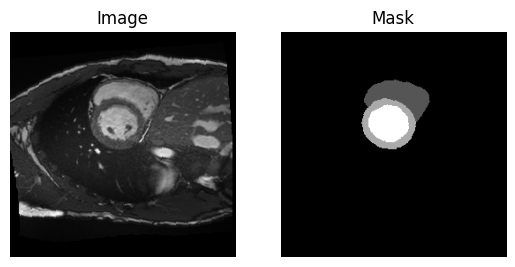

Done!


In [7]:
for sample in supervised_loader:
    images, masks, _ = sample
    print(sample)
    print('Image batch dimensions: ', images.size())
    print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(masks[0,0,:,:], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

    break
print('Done!')


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

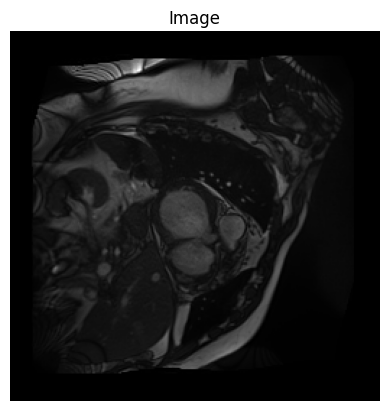

0


In [8]:
for i, sample in enumerate(unsupervised_loader):
    print(sample )
    images, maskNone, _ = sample
    print('Image batch dimensions: ', images.size())
    # print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask        
    plt.figure()
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.show()
    break
print(i)

## Modèle basique : Entraînement avec les GT uniquement 

### Paramètres de l'entraînement

In [9]:
# Define hyperparameters

lr =  0.001    # Learning Rate
total_epochs = 100  # Number of epochs

### Entraînement du modèle 

In [10]:
def runTraining(writer: SummaryWriter):
    print("-" * 40)
    print("~~~~~~~~  Starting the training... ~~~~~~")
    print("-" * 40)

    num_classes = 4

    # Set device depending on the availability of GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    # elif torch.mps.is_available():  # Apple M-series of chips
    #     device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = "Test_Model"
    print(" Model Name: {}".format(modelName))

    # Create the model
    net = UNet(num_classes).to(device)

    print(
        "Total params: {0:,}".format(
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    # Define the loss function
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES
    # if torch.cuda.is_available():
    #     net.cuda()
    #     softMax.cuda()
    #     CE_loss.cuda()

    ## OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

    ### To save statistics ####
    train_losses = []
    train_dc_losses = []
    val_losses = []
    val_dc_losses = []

    best_loss_val = 1000

    directory = "Results/Statistics/" + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory) == False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for epoch in range(total_epochs):
        net.train()

        num_batches = len(supervised_loader)
        print("Number of batches: ", num_batches)

        running_train_loss = 0
        running_dice_loss = 0

        # Training loop
        for idx, data in enumerate(supervised_loader):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data
            # print("Type of labels before to_var:", type(labels))
            ### From numpy to torch variables
            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            # Forward pass
            net_predictions = net(images)

            # Get the segmentation classes
            segmentation_classes = utils.getTargetSegmentation(labels)

            # Compute the loss
            loss = CE_loss(net_predictions, segmentation_classes)
            running_train_loss += loss.item()
            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            running_dice_loss += dice_loss

            # Backprop
            loss.backward()
            optimizer.step()

            # Add the loss to the tensorboard every 5 batches
            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )
                writer.add_scalar(
                    "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )

            if idx % 100 == 0:
                # Also add visualizations of the images
                probs = torch.softmax(net_predictions, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                writer.add_figure('predictions vs. actuals',
                            utils.plot_net_predictions(images, labels, y_pred, batch_size),
                            global_step=epoch * len(supervised_loader) + idx)

            # THIS IS JUST TO VISUALIZE THE TRAINING
            printProgressBar(
                idx + 1,
                num_batches,
                prefix="[Training] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
            )

        train_loss = running_train_loss / num_batches
        train_losses.append(train_loss)

        train_dc_loss = running_dice_loss / num_batches
        train_dc_losses.append(train_dc_loss)

        net.eval()
        val_running_loss = 0
        val_running_dc = 0

        # Validation loop
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                images, labels, img_names = data

                labels = utils.to_var(labels).to(device)
                images = utils.to_var(images).to(device)

                net_predictions = net(images)

                segmentation_classes = utils.getTargetSegmentation(labels)

                loss = CE_loss(net_predictions, segmentation_classes) 
                val_running_loss += loss.item()

                # dice_loss = dice_coefficient(net_predictions, labels)
                dice_loss = utils.compute_dsc(net_predictions, labels)
                val_running_dc += dice_loss

                if idx % 10 == 0:
                    writer.add_scalar(
                        "Loss/val",
                        val_running_loss / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )
                    writer.add_scalar(
                        "Dice/val",
                        val_running_dc / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )

                printProgressBar(
                    idx + 1,
                    len(val_loader),
                    prefix="[Validation] Epoch: {} ".format(epoch),
                    length=15,
                    suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
                )

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        dc_loss = val_running_dc / len(val_loader)
        val_dc_losses.append(dc_loss)

        # Check if model performed best and save it if true
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            if not os.path.exists("./models/" + modelName):
                os.makedirs("./models/" + modelName)
            torch.save(
                net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
            )

        printProgressBar(
            num_batches,
            num_batches,
            done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
                epoch, train_loss, train_dc_loss, val_loss
            ),
        )

        np.save(os.path.join(directory, "Losses.npy"), train_losses)
    writer.flush()  # Flush the writer to ensure that all the data is written to disk

In [33]:
# Set up Tensorboard writer
writer = SummaryWriter()
runTraining(writer)
writer.close()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  102
[Training] Epoch: 0 [DONE]                                 
[Validation] Epoch: 0 [DONE]                                 
[Epoch: 0, TrainLoss: 1.1501, TrainDice: 0.0544, ValLoss: 0.8057                                             
Number of batches:  102
[Training] Epoch: 1 [DONE]                                 
[Validation] Epoch: 1 [DONE]                                 
[Epoch: 1, TrainLoss: 0.5780, TrainDice: 0.0544, ValLoss: 0.4963                                             
Number of batches:  102
[Training] Epoch: 2 [DONE]                                 
[Validation] Epoch: 2 [DONE]                                 
[Epoch: 2, TrainLoss: 0.3958, TrainDice: 0.0544, ValLoss: 0.357

### Tests (validation)

### Sauvegarde du modèle 

In [27]:
from utils import inference

epoch_to_load = 
model = UNet(4)
model.load_state_dict(torch.load(f"./models/Test_Model/{epoch_to_load}_Epoch"))
inf_losses = inference(model, val_loader, "test", epoch_to_load)

SyntaxError: invalid syntax (3711175464.py, line 3)

## Model using both labeled and unlabeled data (Teacher)

### Hyperparameters of the model

In [11]:
# Define hyperparameters

lr =  0.005    # Learning Rate
total_epochs = 100  # Number of epochs

### Example of loop

In this exemple, we modified the structure of the code to use iterators instead. In each epoch, we see the whole range of supervised data and one time each unsupervised data. We can also try to see once the supervised data and to see random images of unsupervised data, which could mean we would not be able to see it all. 

In [12]:
# supervised_iter = iter(supervised_loader)
# unsupervised_iter = iter(unsupervised_loader)

# for epoch in range(total_epochs):
#     num_batches = max(len(supervised_loader), len(unsupervised_loader))
#     for idx in range(num_batches):
#         try :
#             supervised_data = next(supervised_iter)
#         except StopIteration:
#             supervised_iter = iter(supervised_loader)
#             supervised_data= next(supervised_iter)

#         print(supervised_data)
#         print('Supervised batch')   
#         try :
#             unsupervised_data = next(unsupervised_iter)
#         except StopIteration:
#             unsupervised_iter = iter(unsupervised_loader)
#             unsupervised_data = next(unsupervised_iter)
        
#         print(unsupervised_data)
#         print('Unsupervised batch')
#         break
                

### Transformation consistency regularisation

The transformation consistency consists in the principle that transformation T suchs as rotation and flipping should affect the mask f(y) only by the same rotation, which means that f and T should be symetrical. In this implementation, we used the 2-norm to measure the difference, and we included it in the optimisation problem.  $\mathcal{L}_{TC}(y_u) = \|f(T(y_u))-T(F(y))\|_2$

In [12]:
from torchvision import transforms

class ConsistencyRegularization(nn.Module):
    def __init__(self, transformation_fn, loss_fn=nn.MSELoss()):
        """
        Régularisation basée sur la consistance à la transformation.

        Args:
            transformation_fn (callable): Fonction d'augmentation/transformation appliquée aux images.
            loss_fn (callable): Fonction de perte utilisée pour comparer les prédictions (par défaut MSELoss).
        """
        super(ConsistencyRegularization, self).__init__()
        self.transformation_fn = transformation_fn
        self.loss_fn = loss_fn

    def forward(self, model, images):
        """
        Calcule la perte de consistance.

        Args:
            model (torch.nn.Module): Le modèle de segmentation.
            images (torch.Tensor): Batch d'images d'entrée.

        Returns:
            torch.Tensor: La perte de consistance.
        """
        with torch.no_grad():
            # Prédictions de base
            original_predictions = F.softmax(model(images), dim=1)

        # Augmenter les images
        augmented_images = self.transformation_fn(images)

        # Prédictions pour les images augmentées
        augmented_predictions = F.softmax(model(augmented_images), dim=1)

        # Calcul de la perte de consistance
        consistency_loss = self.loss_fn(original_predictions, augmented_predictions)

        return consistency_loss
    



### Training of the model 

At each epoch, the model sees once every exemple of unlabeled data, and sees several time the labeled data. We first train it with the labeled data, and then we train it on the unsupervised data. 

In [ ]:
writer = SummaryWriter()

print("-" * 40)
print("~~~~~~~~  Starting the training... ~~~~~~")
print("-" * 40)

num_classes = 4
alpha = 0.1

# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.mps.is_available():  # Apple M-series of chips
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
modelName = "SemiSupervised-TransformConsistency"
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
net = UNet(num_classes).to(device)

print(
    "Total params: {0:,}".format(
        sum(p.numel() for p in net.parameters() if p.requires_grad)
    )
)

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax(dim=1)
CE_loss = torch.nn.CrossEntropyLoss()
consistency_regularizer = ConsistencyRegularization(transformation_fn=transforms.RandomHorizontalFlip())


## PUT EVERYTHING IN GPU RESOURCES
# if torch.cuda.is_available():
#     net.cuda()
#     softMax.cuda()
#     CE_loss.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### To save statistics ####
train_losses = []
train_dc_losses = []
val_losses = []
val_dc_losses = []

best_loss_val = 1000

directory = "Results/Statistics/" + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory) == False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for epoch in range(total_epochs):
    net.train()
    supervised_iter = iter(supervised_loader)
    unsupervised_iter = iter(unsupervised_loader)
    
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    print("Number of batches: ", num_batches)

    running_train_loss = 0
    running_dice_loss = 0

    # Training loop
    for idx in range(num_batches):
        ### SUPERVISED BATCH
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data = next(supervised_iter)

        ### Set to zero all the gradients
        net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = supervised_data

        ### From numpy to torch variables
        labels = utils.to_var(labels).to(device)
        images = utils.to_var(images).to(device)

        # Forward pass
        net_predictions = net(images)

        # Get the segmentation classes
        segmentation_classes = utils.getTargetSegmentation(labels)

        # Compute the loss
        ce_loss = CE_loss(net_predictions, segmentation_classes)
        running_train_loss += ce_loss.item()
        # dice_loss = dice_coefficient(net_predictions, labels)
        dice_loss = utils.compute_dsc(net_predictions, labels)
        running_dice_loss += dice_loss

        # Backprop
        ce_loss.backward()
        optimizer.step()

        ### UNSUPERVISED BATCH
        try :
            unsupervised_data = next(unsupervised_iter)
        except StopIteration:
            unsupervised_iter = iter(unsupervised_loader)
            unsupervised_data = next(unsupervised_iter)
        
        unsupervised_images, _, _ = unsupervised_data
        unsupervised_images = utils.to_var(unsupervised_images).to(device)

        net.zero_grad()
        optimizer.zero_grad()

        consistency_loss = consistency_regularizer(net, unsupervised_images)
        (alpha * consistency_loss).backward()
        optimizer.step()

        running_train_loss += consistency_loss.item()
        running_dice_loss += 0

        # Add the loss to the tensorboard every 5 batches
        if idx % 10 == 0:
            writer.add_scalar(
                "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            writer.add_scalar(
                "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )

        if idx % 100 == 0:
            # Also add visualizations of the images
            probs = torch.softmax(net_predictions, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            writer.add_figure('predictions vs. actuals',
                        utils.plot_net_predictions(images, labels, y_pred, batch_size),
                        global_step=epoch * len(supervised_loader) + idx)

        # THIS IS JUST TO VISUALIZE THE TRAINING
        printProgressBar(
            idx + 1,
            num_batches,
            prefix="[Training] Epoch: {} ".format(epoch),
            length=15,
            suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
        )

    train_loss = running_train_loss / num_batches
    train_losses.append(train_loss)

    train_dc_loss = running_dice_loss / num_batches
    train_dc_losses.append(train_dc_loss)

    net.eval()
    val_running_loss = 0
    val_running_dc = 0

    # Validation loop
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            images, labels, img_names = data

            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            net_predictions = net(images)

            segmentation_classes = utils.getTargetSegmentation(labels)

            loss = CE_loss(net_predictions, segmentation_classes) 
            val_running_loss += loss.item()

            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            val_running_dc += dice_loss

            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/val",
                    val_running_loss / (idx + 1),
                    epoch * len(val_loader) + idx,
                )
                writer.add_scalar(
                    "Dice/val",
                    val_running_dc / (idx + 1),
                    epoch * len(val_loader) + idx,
                )

            printProgressBar(
                idx + 1,
                len(val_loader),
                prefix="[Validation] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
            )

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    dc_loss = val_running_dc / len(val_loader)
    val_dc_losses.append(dc_loss)

    # Check if model performed best and save it if true
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        if not os.path.exists("./models/" + modelName):
            os.makedirs("./models/" + modelName)
        torch.save(
            net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
        )

    printProgressBar(
        num_batches,
        num_batches,
        done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
            epoch, train_loss, train_dc_loss, val_loss
        ),
    )

    np.save(os.path.join(directory, "Losses.npy"), train_losses)
writer.flush()  # Flush the writer to ensure that all the data is written to disk
writer.close()

Affichage

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: SemiSupervised-TransformConsistency
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  126
[Training] Epoch: 0 [DONE]                                 
[Validation] Epoch: 0 [DONE]                                 
[Epoch: 0, TrainLoss: 0.4010, TrainDice: 0.0536, ValLoss: 0.1547                                             
Number of batches:  126
[Training] Epoch: 1 [DONE]                                 
[Validation] Epoch: 1 [DONE]                                 
[Epoch: 1, TrainLoss: 0.1050, TrainDice: 0.0538, ValLoss: 0.1348                                             
Number of batches:  126
[Training] Epoch: 2 [DONE]                                 
[Validation] Epoch: 2 [DONE]                                 
[Epoch: 2, TrainLoss: 0.0857, TrainDice: 0.0539, ValLoss: 0.0873                                             
Number of batches:  126
[Training] Epoch: 3 [DONE]                                 
[Validation] Epoch: 3 [DONE]                                 
[Epoch: 3, TrainLoss: 0.0791, TrainDice: 0.0540, ValLoss: 0.0952                                             
Number of batches:  126
[Training] Epoch: 4 [DONE]                                 
[Validation] Epoch: 4 [DONE]                                 
[Epoch: 4, TrainLoss: 0.0748, TrainDice: 0.0542, ValLoss: 0.0720                                             
Number of batches:  126
[Training] Epoch: 5 [DONE]                                 
[Validation] Epoch: 5 [DONE]                                 
[Epoch: 5, TrainLoss: 0.0700, TrainDice: 0.0547, ValLoss: 0.1271                                             
Number of batches:  126
[Training] Epoch: 6 [DONE]                                 
[Validation] Epoch: 6 [DONE]                                 
[Epoch: 6, TrainLoss: 0.0684, TrainDice: 0.0543, ValLoss: 0.0950                                             
Number of batches:  126
[Training] Epoch: 7 [DONE]                                 
[Validation] Epoch: 7 [DONE]                                 
[Epoch: 7, TrainLoss: 0.0667, TrainDice: 0.0546, ValLoss: 0.0782                                             
Number of batches:  126
[Training] Epoch: 8 [DONE]                                 
[Validation] Epoch: 8 [DONE]                                 
[Epoch: 8, TrainLoss: 0.0634, TrainDice: 0.0545, ValLoss: 0.0733                                             
Number of batches:  126
[Training] Epoch: 9 [DONE]                                 
[Validation] Epoch: 9 [DONE]                                 
[Epoch: 9, TrainLoss: 0.0584, TrainDice: 0.0542, ValLoss: 0.0932                                             
Number of batches:  126
[Training] Epoch: 10 [DONE]                                 
[Validation] Epoch: 10 [DONE]                                 
[Epoch: 10, TrainLoss: 0.0634, TrainDice: 0.0547, ValLoss: 0.0867                                            
Number of batches:  126
[Training] Epoch: 11 [DONE]                                 
[Validation] Epoch: 11 [DONE]                                 
[Epoch: 11, TrainLoss: 0.0559, TrainDice: 0.0546, ValLoss: 0.0699                                            
Number of batches:  126
[Training] Epoch: 12 [DONE]                                 
[Validation] Epoch: 12 [DONE]                                 
[Epoch: 12, TrainLoss: 0.0572, TrainDice: 0.0538, ValLoss: 0.0701                                            
Number of batches:  126
[Training] Epoch: 13 [DONE]                                 
[Validation] Epoch: 13 [DONE]                                 
[Epoch: 13, TrainLoss: 0.0500, TrainDice: 0.0541, ValLoss: 0.0543                                            
Number of batches:  126
[Training] Epoch: 14 [DONE]                                 
[Validation] Epoch: 14 [DONE]                                 
[Epoch: 14, TrainLoss: 0.0496, TrainDice: 0.0543, ValLoss: 0.1026                                            
Number of batches:  126
[Training] Epoch: 15 [DONE]                                 
[Validation] Epoch: 15 [DONE]                                 
[Epoch: 15, TrainLoss: 0.0496, TrainDice: 0.0541, ValLoss: 0.0611                                            
Number of batches:  126
[Training] Epoch: 16 [DONE]                                 
[Validation] Epoch: 16 [DONE]                                 
[Epoch: 16, TrainLoss: 0.0470, TrainDice: 0.0551, ValLoss: 0.0524                                            
Number of batches:  126
[Training] Epoch: 17 [DONE]                                 
[Validation] Epoch: 17 [DONE]                                 
[Epoch: 17, TrainLoss: 0.0467, TrainDice: 0.0539, ValLoss: 0.0880                                            
Number of batches:  126
[Training] Epoch: 18 [DONE]                                 
[Validation] Epoch: 18 [DONE]                                 
[Epoch: 18, TrainLoss: 0.0453, TrainDice: 0.0548, ValLoss: 0.0545                                            
Number of batches:  126
[Training] Epoch: 19 [DONE]                                 
[Validation] Epoch: 19 [DONE]                                 
[Epoch: 19, TrainLoss: 0.0447, TrainDice: 0.0535, ValLoss: 0.0436                                            
Number of batches:  126
[Training] Epoch: 20 [DONE]                                 
[Validation] Epoch: 20 [DONE]                                 
[Epoch: 20, TrainLoss: 0.0430, TrainDice: 0.0556, ValLoss: 0.0708                                            
Number of batches:  126
[Training] Epoch: 21 [DONE]                                 
[Validation] Epoch: 21 [DONE]                                 
[Epoch: 21, TrainLoss: 0.0407, TrainDice: 0.0536, ValLoss: 0.0457                                            
Number of batches:  126
[Training] Epoch: 22 [DONE]                                 
[Validation] Epoch: 22 [DONE]                                 
[Epoch: 22, TrainLoss: 0.0423, TrainDice: 0.0537, ValLoss: 0.0856                                            
Number of batches:  126
[Training] Epoch: 23 [DONE]                                 
[Validation] Epoch: 23 [DONE]                                 
[Epoch: 23, TrainLoss: 0.0481, TrainDice: 0.0536, ValLoss: 0.0758                                            
Number of batches:  126
[Training] Epoch: 24 [DONE]                                 
[Validation] Epoch: 24 [DONE]                                 
[Epoch: 24, TrainLoss: 0.0440, TrainDice: 0.0549, ValLoss: 0.0443                                            
Number of batches:  126
[Training] Epoch: 25 [DONE]                                 
[Validation] Epoch: 25 [DONE]                                 
[Epoch: 25, TrainLoss: 0.0387, TrainDice: 0.0547, ValLoss: 0.1073                                            
Number of batches:  126
[Training] Epoch: 26 [DONE]                                 
[Validation] Epoch: 26 [DONE]                                 
[Epoch: 26, TrainLoss: 0.0379, TrainDice: 0.0535, ValLoss: 0.0571                                            
Number of batches:  126
[Training] Epoch: 27 [DONE]                                 
[Validation] Epoch: 27 [DONE]                                 
[Epoch: 27, TrainLoss: 0.0388, TrainDice: 0.0569, ValLoss: 0.0504                                            
Number of batches:  126
[Training] Epoch: 28 [DONE]                                 
[Validation] Epoch: 28 [DONE]                                 
[Epoch: 28, TrainLoss: 0.0389, TrainDice: 0.0540, ValLoss: 0.0726                                            
Number of batches:  126
[Training] Epoch: 29 [DONE]                                 
[Validation] Epoch: 29 [DONE]                                 
[Epoch: 29, TrainLoss: 0.0371, TrainDice: 0.0559, ValLoss: 0.0492                                            
Number of batches:  126
[Training] Epoch: 30 [DONE]                                 
[Validation] Epoch: 30 [DONE]                                 
[Epoch: 30, TrainLoss: 0.0362, TrainDice: 0.0539, ValLoss: 0.0635                                            
Number of batches:  126
[Training] Epoch: 31 [DONE]                                 
[Validation] Epoch: 31 [DONE]                                 
[Epoch: 31, TrainLoss: 0.0383, TrainDice: 0.0548, ValLoss: 0.0529                                            
Number of batches:  126
[Training] Epoch: 32 [DONE]                                 
[Validation] Epoch: 32 [DONE]                                 
[Epoch: 32, TrainLoss: 0.0375, TrainDice: 0.0536, ValLoss: 0.0496                                            
Number of batches:  126
[Training] Epoch: 33 [DONE]                                 
[Validation] Epoch: 33 [DONE]                                 
[Epoch: 33, TrainLoss: 0.0357, TrainDice: 0.0539, ValLoss: 0.0634                                            
Number of batches:  126
[Training] Epoch: 34 [DONE]                                 
[Validation] Epoch: 34 [DONE]                                 
[Epoch: 34, TrainLoss: 0.0359, TrainDice: 0.0531, ValLoss: 0.0515                                            
Number of batches:  126
[Training] Epoch: 35 [DONE]                                 
[Validation] Epoch: 35 [DONE]                                 
[Epoch: 35, TrainLoss: 0.0352, TrainDice: 0.0549, ValLoss: 0.1153                                            
Number of batches:  126
[Training] Epoch: 36 [DONE]                                 
[Validation] Epoch: 36 [DONE]                                 
[Epoch: 36, TrainLoss: 0.0362, TrainDice: 0.0540, ValLoss: 0.0461                                            
Number of batches:  126
[Training] Epoch: 37 [DONE]                                 
[Validation] Epoch: 37 [DONE]                                 
[Epoch: 37, TrainLoss: 0.0340, TrainDice: 0.0550, ValLoss: 0.0458                                            
Number of batches:  126
[Training] Epoch: 38 [DONE]                                 
[Validation] Epoch: 38 [DONE]                                 
[Epoch: 38, TrainLoss: 0.0355, TrainDice: 0.0538, ValLoss: 0.0678                                            
Number of batches:  126
[Training] Epoch: 39 [DONE]                                 
[Validation] Epoch: 39 [DONE]                                 
[Epoch: 39, TrainLoss: 0.0324, TrainDice: 0.0554, ValLoss: 0.0376                                            
Number of batches:  126
[Training] Epoch: 40 [DONE]                                 
[Validation] Epoch: 40 [DONE]                                 
[Epoch: 40, TrainLoss: 0.0339, TrainDice: 0.0551, ValLoss: 0.1432                                            
Number of batches:  126
[Training] Epoch: 41 [DONE]                                 
[Validation] Epoch: 41 [DONE]                                 
[Epoch: 41, TrainLoss: 0.0335, TrainDice: 0.0559, ValLoss: 0.0537                                            
Number of batches:  126
[Training] Epoch: 42 [DONE]                                 
[Validation] Epoch: 42 [DONE]                                 
[Epoch: 42, TrainLoss: 0.0325, TrainDice: 0.0552, ValLoss: 0.0364                                            
Number of batches:  126
[Training] Epoch: 43 [DONE]                                 
[Validation] Epoch: 43 [DONE]                                 
[Epoch: 43, TrainLoss: 0.0326, TrainDice: 0.0561, ValLoss: 0.0518                                            
Number of batches:  126
[Training] Epoch: 44 [DONE]                                 
[Validation] Epoch: 44 [DONE]                                 
[Epoch: 44, TrainLoss: 0.0305, TrainDice: 0.0549, ValLoss: 0.0684                                            
Number of batches:  126
[Training] Epoch: 45 [DONE]                                 
[Validation] Epoch: 45 [DONE]                                 
[Epoch: 45, TrainLoss: 0.0314, TrainDice: 0.0535, ValLoss: 0.0470                                            
Number of batches:  126
[Training] Epoch: 46 [DONE]                                 
[Validation] Epoch: 46 [DONE]                                 
[Epoch: 46, TrainLoss: 0.0328, TrainDice: 0.0547, ValLoss: 0.0785                                            
Number of batches:  126
[Training] Epoch: 47 [DONE]                                 
[Validation] Epoch: 47 [DONE]                                 
[Epoch: 47, TrainLoss: 0.0310, TrainDice: 0.0553, ValLoss: 0.0687                                            
Number of batches:  126
[Training] Epoch: 48 [DONE]                                 
[Validation] Epoch: 48 [DONE]                                 
[Epoch: 48, TrainLoss: 0.0315, TrainDice: 0.0544, ValLoss: 0.0776                                            
Number of batches:  126
[Training] Epoch: 49 [DONE]                                 
[Validation] Epoch: 49 [DONE]                                 
[Epoch: 49, TrainLoss: 0.0323, TrainDice: 0.0549, ValLoss: 0.0610                                            
Number of batches:  126
[Training] Epoch: 50 [DONE]                                 
[Validation] Epoch: 50 [DONE]                                 
[Epoch: 50, TrainLoss: 0.0300, TrainDice: 0.0541, ValLoss: 0.0746                                            
Number of batches:  126
[Training] Epoch: 51 [DONE]                                 
[Validation] Epoch: 51 [DONE]                                 
[Epoch: 51, TrainLoss: 0.0306, TrainDice: 0.0541, ValLoss: 0.0751                                            
Number of batches:  126
[Training] Epoch: 52 [DONE]                                 
[Validation] Epoch: 52 [DONE]                                 
[Epoch: 52, TrainLoss: 0.0317, TrainDice: 0.0545, ValLoss: 0.0509                                            
Number of batches:  126
[Training] Epoch: 53 [DONE]                                 
[Validation] Epoch: 53 [DONE]                                 
[Epoch: 53, TrainLoss: 0.0303, TrainDice: 0.0529, ValLoss: 0.0550                                            
Number of batches:  126
[Training] Epoch: 54 [DONE]                                 
[Validation] Epoch: 54 [DONE]                                 
[Epoch: 54, TrainLoss: 0.0320, TrainDice: 0.0544, ValLoss: 0.0505                                            
Number of batches:  126
[Training] Epoch: 55 [DONE]                                 
[Validation] Epoch: 55 [DONE]                                 
[Epoch: 55, TrainLoss: 0.0289, TrainDice: 0.0558, ValLoss: 0.0358                                            
Number of batches:  126
[Training] Epoch: 56 [DONE]                                 
[Validation] Epoch: 56 [DONE]                                 
[Epoch: 56, TrainLoss: 0.0312, TrainDice: 0.0561, ValLoss: 0.0405                                            
Number of batches:  126
[Training] Epoch: 57 [DONE]                                 
[Validation] Epoch: 57 [DONE]                                 
[Epoch: 57, TrainLoss: 0.0313, TrainDice: 0.0562, ValLoss: 0.0524                                            
Number of batches:  126
[Training] Epoch: 58 [DONE]                                 
[Validation] Epoch: 58 [DONE]                                 
[Epoch: 58, TrainLoss: 0.0296, TrainDice: 0.0551, ValLoss: 0.0405                                            
Number of batches:  126
[Training] Epoch: 59 [DONE]                                 
[Validation] Epoch: 59 [DONE]                                 
[Epoch: 59, TrainLoss: 0.0285, TrainDice: 0.0558, ValLoss: 0.0389                                            
Number of batches:  126
[Training] Epoch: 60 [DONE]                                 
[Validation] Epoch: 60 [DONE]                                 
[Epoch: 60, TrainLoss: 0.0302, TrainDice: 0.0544, ValLoss: 0.0439                                            
Number of batches:  126
[Training] Epoch: 61 [DONE]                                 
[Validation] Epoch: 61 [DONE]                                 
[Epoch: 61, TrainLoss: 0.0279, TrainDice: 0.0551, ValLoss: 0.0444                                            
Number of batches:  126
[Training] Epoch: 62 [DONE]                                 
[Validation] Epoch: 62 [DONE]                                 
[Epoch: 62, TrainLoss: 0.0293, TrainDice: 0.0541, ValLoss: 0.0590                                            
Number of batches:  126
[Training] Epoch: 63 [DONE]                                 
[Validation] Epoch: 63 [DONE]                                 
[Epoch: 63, TrainLoss: 0.0293, TrainDice: 0.0531, ValLoss: 0.0380                                            
Number of batches:  126
[Training] Epoch: 64 [DONE]                                 
[Validation] Epoch: 64 [DONE]                                 
[Epoch: 64, TrainLoss: 0.0271, TrainDice: 0.0540, ValLoss: 0.1047                                            
Number of batches:  126
[Training] Epoch: 65 [DONE]                                 
[Validation] Epoch: 65 [DONE]                                 
[Epoch: 65, TrainLoss: 0.0308, TrainDice: 0.0546, ValLoss: 0.0523                                            
Number of batches:  126
[Training] Epoch: 66 [DONE]                                 
[Validation] Epoch: 66 [DONE]                                 
[Epoch: 66, TrainLoss: 0.0277, TrainDice: 0.0547, ValLoss: 0.0738                                            
Number of batches:  126
[Training] Epoch: 67 [DONE]                                 
[Validation] Epoch: 67 [DONE]                                 
[Epoch: 67, TrainLoss: 0.0283, TrainDice: 0.0558, ValLoss: 0.0449                                            
Number of batches:  126
[Training] Epoch: 68 [DONE]                                 
[Validation] Epoch: 68 [DONE]                                 
[Epoch: 68, TrainLoss: 0.0275, TrainDice: 0.0541, ValLoss: 0.0497                                            
Number of batches:  126
[Training] Epoch: 69 [DONE]                                 
[Validation] Epoch: 69 [DONE]                                 
[Epoch: 69, TrainLoss: 0.0270, TrainDice: 0.0560, ValLoss: 0.0440                                            
Number of batches:  126
[Training] Epoch: 70 [DONE]                                 
[Validation] Epoch: 70 [DONE]                                 
[Epoch: 70, TrainLoss: 0.0285, TrainDice: 0.0541, ValLoss: 0.0444                                            
Number of batches:  126
[Training] Epoch: 71 [DONE]                                 
[Validation] Epoch: 71 [DONE]                                 
[Epoch: 71, TrainLoss: 0.0297, TrainDice: 0.0549, ValLoss: 0.0496                                            
Number of batches:  126
[Training] Epoch: 72 [DONE]                                 
[Validation] Epoch: 72 [DONE]                                 
[Epoch: 72, TrainLoss: 0.0282, TrainDice: 0.0547, ValLoss: 0.0387                                            
Number of batches:  126
[Training] Epoch: 73 [DONE]                                 
[Validation] Epoch: 73 [DONE]                                 
[Epoch: 73, TrainLoss: 0.0273, TrainDice: 0.0546, ValLoss: 0.0443                                            
Number of batches:  126
[Training] Epoch: 74 [DONE]                                 
[Validation] Epoch: 74 [DONE]                                 
[Epoch: 74, TrainLoss: 0.0269, TrainDice: 0.0539, ValLoss: 0.0553                                            
Number of batches:  126
[Training] Epoch: 75 [DONE]                                 
[Validation] Epoch: 75 [DONE]                                 
[Epoch: 75, TrainLoss: 0.0274, TrainDice: 0.0541, ValLoss: 0.0584                                            
Number of batches:  126
[Training] Epoch: 76 [DONE]                                 
[Validation] Epoch: 76 [DONE]                                 
[Epoch: 76, TrainLoss: 0.0296, TrainDice: 0.0547, ValLoss: 0.0357                                            
Number of batches:  126
[Training] Epoch: 77 [DONE]                                 
[Validation] Epoch: 77 [DONE]                                 
[Epoch: 77, TrainLoss: 0.0265, TrainDice: 0.0538, ValLoss: 0.0531                                            
Number of batches:  126
[Training] Epoch: 78 [DONE]                                 
[Validation] Epoch: 78 [DONE]                                 
[Epoch: 78, TrainLoss: 0.0254, TrainDice: 0.0540, ValLoss: 0.0453                                            
Number of batches:  126
[Training] Epoch: 79 [DONE]                                 
[Validation] Epoch: 79 [DONE]                                 
[Epoch: 79, TrainLoss: 0.0286, TrainDice: 0.0549, ValLoss: 0.0588                                            
Number of batches:  126
[Training] Epoch: 80 [DONE]                                 
[Validation] Epoch: 80 [DONE]                                 
[Epoch: 80, TrainLoss: 0.0278, TrainDice: 0.0537, ValLoss: 0.0429                                            
Number of batches:  126
[Training] Epoch: 81 [DONE]                                 
[Validation] Epoch: 81 [DONE]                                 
[Epoch: 81, TrainLoss: 0.0256, TrainDice: 0.0554, ValLoss: 0.0490                                            
Number of batches:  126
[Training] Epoch: 82 [DONE]                                 
[Validation] Epoch: 82 [DONE]                                 
[Epoch: 82, TrainLoss: 0.0262, TrainDice: 0.0533, ValLoss: 0.0557                                            
Number of batches:  126
[Training] Epoch: 83 [DONE]                                 
[Validation] Epoch: 83 [DONE]                                 
[Epoch: 83, TrainLoss: 0.0271, TrainDice: 0.0531, ValLoss: 0.0582                                            
Number of batches:  126
[Training] Epoch: 84 [DONE]                                 
[Validation] Epoch: 84 [DONE]                                 
[Epoch: 84, TrainLoss: 0.0248, TrainDice: 0.0545, ValLoss: 0.0676                                            
Number of batches:  126
[Training] Epoch: 85 [DONE]                                 
[Validation] Epoch: 85 [DONE]                                 
[Epoch: 85, TrainLoss: 0.0271, TrainDice: 0.0550, ValLoss: 0.0490                                            
Number of batches:  126
[Training] Epoch: 86 [DONE]                                 
[Validation] Epoch: 86 [DONE]                                 
[Epoch: 86, TrainLoss: 0.0265, TrainDice: 0.0541, ValLoss: 0.0458                                            
Number of batches:  126
[Training] Epoch: 87 [DONE]                                 
[Validation] Epoch: 87 [DONE]                                 
[Epoch: 87, TrainLoss: 0.0269, TrainDice: 0.0546, ValLoss: 0.0403                                            
Number of batches:  126
[Training] Epoch: 88 [DONE]                                 
[Validation] Epoch: 88 [DONE]                                 
[Epoch: 88, TrainLoss: 0.0270, TrainDice: 0.0547, ValLoss: 0.0444                                            
Number of batches:  126
[Training] Epoch: 89 [DONE]                                 
[Validation] Epoch: 89 [DONE]                                 
[Epoch: 89, TrainLoss: 0.0261, TrainDice: 0.0544, ValLoss: 0.0368                                            
Number of batches:  126
[Training] Epoch: 90 [DONE]                                 
[Validation] Epoch: 90 [DONE]                                 
[Epoch: 90, TrainLoss: 0.0231, TrainDice: 0.0533, ValLoss: 0.0608                                            
Number of batches:  126
[Training] Epoch: 91 [DONE]                                 
[Validation] Epoch: 91 [DONE]                                 
[Epoch: 91, TrainLoss: 0.0246, TrainDice: 0.0533, ValLoss: 0.0516                                            
Number of batches:  126
[Training] Epoch: 92 [DONE]                                 
[Validation] Epoch: 92 [DONE]                                 
[Epoch: 92, TrainLoss: 0.0244, TrainDice: 0.0541, ValLoss: 0.0362                                            
Number of batches:  126
[Training] Epoch: 93 [DONE]                                 
[Validation] Epoch: 93 [DONE]                                 
[Epoch: 93, TrainLoss: 0.0268, TrainDice: 0.0551, ValLoss: 0.0463                                            
Number of batches:  126
[Training] Epoch: 94 [DONE]                                 
[Validation] Epoch: 94 [DONE]                                 
[Epoch: 94, TrainLoss: 0.0239, TrainDice: 0.0534, ValLoss: 0.0381                                            
Number of batches:  126
[Training] Epoch: 95 [DONE]                                 
[Validation] Epoch: 95 [DONE]                                 
[Epoch: 95, TrainLoss: 0.0237, TrainDice: 0.0529, ValLoss: 0.0465                                            
Number of batches:  126
[Training] Epoch: 96 [DONE]                                 
[Validation] Epoch: 96 [DONE]                                 
[Epoch: 96, TrainLoss: 0.0246, TrainDice: 0.0546, ValLoss: 0.0422                                            
Number of batches:  126
[Training] Epoch: 97 [DONE]                                 
[Validation] Epoch: 97 [DONE]                                 
[Epoch: 97, TrainLoss: 0.0242, TrainDice: 0.0541, ValLoss: 0.0508                                            
Number of batches:  126
[Training] Epoch: 98 [DONE]                                 
[Validation] Epoch: 98 [DONE]                                 
[Epoch: 98, TrainLoss: 0.0253, TrainDice: 0.0547, ValLoss: 0.0410                                            
Number of batches:  126
[Training] Epoch: 99 [DONE]                                 
[Validation] Epoch: 99 [DONE]                                 
[Epoch: 99, TrainLoss: 0.0239, TrainDice: 0.0525, ValLoss: 0.0644

Tester un modèle déjà enregistré :

In [13]:

epoch_to_load = 
model = UNet(4)
model.load_state_dict(torch.load(f"./models/SemiSupervised-TransformConsistency/{epoch_to_load}_Epoch"))
inf_losses = inference(model, val_loader, "test", epoch_to_load)

[Inference] Getting segmentations...[>                             ] 0.0%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=>                            ] 5.3%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[===>                          ] 10.5%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[====>                         ] 15.8%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[======>                       ] 21.1%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=======>                      ] 26.3%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=========>                    ] 31.6%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[===========>                  ] 36.8%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[============>                 ] 42.1%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[==============>               ] 47.4%t

## Model Student using Pseudo Labels

### Generate pseudo labels

Les pseudo labels ci-dessous sont enregistrées dans Data/train/Img-UnlabeledProbabilities/{numEpoch} sous forme de probabilités,
les prédictions sous forme d'image sont enregistrées dans Data/train/Img-UnlabeledPredictions/{numEpoch},
les comparaisons image d'entrée/segmentation prédite sont enregistrées dans Results/Images/TeacherUnlabeledPredictions

In [17]:
teacher = model #choisir soit net (généré précédemment par entrainement) ou choisir model (modele chargé précédemment)

num_epoch_teacher = 74
inferenceTeacher(teacher, unlabeledEval_loader_full, num_epoch_teacher, device) #predictions sur les unlabeled avec model


len image batch :  126
[Inference] Teacher Inference Done !                                                                         


### Modèle Student

Modele Student initialisé avec les poids du Teacher, entraîné sur les données étiquetées et sur les pseudo-labels par utilisation de la Kullback-Leibler Divergence pondérée (on compare les probabilités des pseudo labels aux probabilités du Student).

In [ ]:
writer = SummaryWriter()

print("-" * 40)
print("~~~~~~~~  Starting the training of the student... ~~~~~~")
print("-" * 40)

num_classes = 4
alpha = 0.1

num_epoch_teacher =  #epoch que l'on veut charger pour teacher
teacher_model_path = #f"./models/SemiSupervised-TransformConsistency/{num_epoch_teacher}_Epoch" #si on prend pour teacher model

# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

print("~~~~~~~~~~~ Creating the UNet Student model ~~~~~~~~~~")
modelName = "Student"
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
student_net = UNet(num_classes).to(device)


#charger les poids du teacher dans le student
try:
    student_net.load_state_dict(torch.load(teacher_model_path))
    print(f"Les poids du modèle Teacher (époque {epoch_to_load}) ont été chargés avec succès dans le modèle Student.")
except Exception as e:
    print(f"Erreur lors du chargement des poids : {e}")

print(
    "Total params: {0:,}".format(
        sum(p.numel() for p in student_net.parameters() if p.requires_grad)
    )
)

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax(dim=1)
CE_loss = torch.nn.CrossEntropyLoss()
consistency_regularizer = ConsistencyRegularization(transformation_fn=transforms.RandomHorizontalFlip())


## PUT EVERYTHING IN GPU RESOURCES
# if torch.cuda.is_available():
#     student_net.cuda()
#     softMax.cuda()
#     CE_loss.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(student_net.parameters(), lr=lr)

### To save statistics ####
train_losses = []
train_dc_losses = []
val_losses = []
val_dc_losses = []

best_loss_val = 1000

directory = "Results/Statistics/" + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory) == False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for epoch in range(total_epochs):
    student_net.train()
    supervised_iter = iter(supervised_loader)
    unsupervised_iter = iter(unsupervised_loader)
    unlabeled_iter = iter(unlabeledEval_loader_full)
    
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    print("Number of batches: ", num_batches)

    running_train_loss = 0
    running_dice_loss = 0

    # Training loop
    for idx in range(num_batches):
        ### SUPERVISED BATCH
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data = next(supervised_iter)

        ### Set to zero all the gradients
        student_net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = supervised_data

        ### From numpy to torch variables
        labels = utils.to_var(labels).to(device)
        images = utils.to_var(images).to(device)

        # Forward pass
        student_net_predictions = student_net(images)

        # Get the segmentation classes
        segmentation_classes = utils.getTargetSegmentation(labels)

        # Compute the loss
        ce_loss = CE_loss(student_net_predictions, segmentation_classes)
        running_train_loss += ce_loss.item()
        dice_loss = utils.compute_dsc(student_net_predictions, labels)
        running_dice_loss += dice_loss

        # Backprop
        ce_loss.backward()
        optimizer.step()

        
        # ### UNSUPERVISED BATCH (consistency regularization)
        # try :
        #     unsupervised_data = next(unsupervised_iter)
        # except StopIteration:
        #     unsupervised_iter = iter(unsupervised_loader)
        #     unsupervised_data = next(unsupervised_iter)
        
        # unsupervised_images, _, _ = unsupervised_data
        # unsupervised_images = utils.to_var(unsupervised_images).to(device)

        # student_net.zero_grad()
        # optimizer.zero_grad()
        
        # consistency_loss = consistency_regularizer(student_net, unsupervised_images)
        # (alpha * consistency_loss).backward()
        # optimizer.step()

        # running_train_loss += consistency_loss.item()
        # running_dice_loss += 0


        ### SEMI-SUPERVISED BATCH (pseudo labels made by Teacher)
        try :
            unlabeled_data = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeledEval_loader_full)
            unlabeled_data = next(unlabeled_iter)

        images, img_names = unlabeled_data
        images = utils.to_var(images).to(device)

        student_net.zero_grad()
        optimizer.zero_grad()

        alphaKLLoss = 0.1 * (epoch / total_epochs)
        
        #on recupere les distributions de proba du teacher pour les unlabeled
        segmentation_class_teacher = get_teacher_proba(num_epoch_teacher, img_names, device)
        #predictions sur unlabeled
        student_net_predictions = student_net(images)
        KLdivLoss = dynamic_weight_kl_div(student_net_predictions, segmentation_class_teacher)

        (alpha * KLdivLoss).backward()
        optimizer.step()

        running_train_loss += alpha * KLdivLoss.item()
       
        running_dice_loss += 0

        
        # Add the loss to the tensorboard every 5 batches
        if idx % 10 == 0:
            writer.add_scalar(
                "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            writer.add_scalar(
                "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )

        if idx % 100 == 0:
            # Also add visualizations of the images
            probs = torch.softmax(student_net_predictions, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            writer.add_figure('predictions vs. actuals',
                        utils.plot_net_predictions(images, labels, y_pred, batch_size),
                        global_step=epoch * len(supervised_loader) + idx)

        # THIS IS JUST TO VISUALIZE THE TRAINING
        printProgressBar(
            idx + 1,
            num_batches,
            prefix="[Training] Epoch: {} ".format(epoch),
            length=15,
            suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
        )

    train_loss = running_train_loss / num_batches
    train_losses.append(train_loss)

    train_dc_loss = running_dice_loss / num_batches
    train_dc_losses.append(train_dc_loss)

    student_net.eval()
    val_running_loss = 0
    val_running_dc = 0

    # Validation loop
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            images, labels, img_names = data

            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            student_net_predictions = student_net(images)

            segmentation_classes = utils.getTargetSegmentation(labels)

            loss = CE_loss(student_net_predictions, segmentation_classes) 
            val_running_loss += loss.item()

            dice_loss = utils.compute_dsc(student_net_predictions, labels)
            val_running_dc += dice_loss

            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/val",
                    val_running_loss / (idx + 1),
                    epoch * len(val_loader) + idx,
                )
                writer.add_scalar(
                    "Dice/val",
                    val_running_dc / (idx + 1),
                    epoch * len(val_loader) + idx,
                )

            printProgressBar(
                idx + 1,
                len(val_loader),
                prefix="[Validation] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
            )

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    dc_loss = val_running_dc / len(val_loader)
    val_dc_losses.append(dc_loss)

    # Check if model performed best and save it if true
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        if not os.path.exists("./models/" + modelName):
            os.makedirs("./models/" + modelName)
        torch.save(
            student_net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
        )

    printProgressBar(
        num_batches,
        num_batches,
        done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
            epoch, train_loss, train_dc_loss, val_loss
        ),
    )

    np.save(os.path.join(directory, "Losses.npy"), train_losses)
writer.flush()  # Flush the writer to ensure that all the data is written to disk
writer.close()

Affichage

----------------------------------------
~~~~~~~~  Starting the training of the student... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: SemiSupervised-TransformConsistency
Les poids du modèle Teacher (époque 74) ont été chargés avec succès dans le modèle Student.
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  126
[Training] Epoch: 0 [DONE]                                 
[Validation] Epoch: 0 [DONE]                                 
[Epoch: 0, TrainLoss: 0.0748, TrainDice: 0.0550, ValLoss: 0.0716                                             
Number of batches:  126
[Training] Epoch: 1 [DONE]                                 
[Validation] Epoch: 1 [DONE]                                 
[Epoch: 1, TrainLoss: 0.0602, TrainDice: 0.0540, ValLoss: 0.0598                                             
Number of batches:  126
[Training] Epoch: 2 [DONE]                                 
[Validation] Epoch: 2 [DONE]                                 
[Epoch: 2, TrainLoss: 0.0559, TrainDice: 0.0540, ValLoss: 0.0481                                             
Number of batches:  126
[Training] Epoch: 3 [DONE]                                 
[Validation] Epoch: 3 [DONE]                                 
[Epoch: 3, TrainLoss: 0.0476, TrainDice: 0.0556, ValLoss: 0.0550                                             
Number of batches:  126
[Training] Epoch: 4 [DONE]                                 
[Validation] Epoch: 4 [DONE]                                 
[Epoch: 4, TrainLoss: 0.0492, TrainDice: 0.0533, ValLoss: 0.1855                                             
Number of batches:  126
[Training] Epoch: 5 [DONE]                                 
[Validation] Epoch: 5 [DONE]                                 
[Epoch: 5, TrainLoss: 0.0520, TrainDice: 0.0548, ValLoss: 0.0637                                             
Number of batches:  126
[Training] Epoch: 6 [DONE]                                 
[Validation] Epoch: 6 [DONE]                                 
[Epoch: 6, TrainLoss: 0.0439, TrainDice: 0.0533, ValLoss: 0.0522                                             
Number of batches:  126
[Training] Epoch: 7 [DONE]                                 
[Validation] Epoch: 7 [DONE]                                 
[Epoch: 7, TrainLoss: 0.0468, TrainDice: 0.0537, ValLoss: 0.0492                                             
Number of batches:  126
[Training] Epoch: 8 [DONE]                                 
[Validation] Epoch: 8 [DONE]                                 
[Epoch: 8, TrainLoss: 0.0424, TrainDice: 0.0535, ValLoss: 0.0447                                             
Number of batches:  126
[Training] Epoch: 9 [DONE]                                 
[Validation] Epoch: 9 [DONE]                                 
[Epoch: 9, TrainLoss: 0.0412, TrainDice: 0.0551, ValLoss: 0.0635                                             
Number of batches:  126
[Training] Epoch: 10 [DONE]                                 
[Validation] Epoch: 10 [DONE]                                 
[Epoch: 10, TrainLoss: 0.0464, TrainDice: 0.0543, ValLoss: 0.0554                                            
Number of batches:  126
[Training] Epoch: 11 [DONE]                                 
[Validation] Epoch: 11 [DONE]                                 
[Epoch: 11, TrainLoss: 0.0392, TrainDice: 0.0554, ValLoss: 0.0683                                            
Number of batches:  126
[Training] Epoch: 12 [DONE]                                 
[Validation] Epoch: 12 [DONE]                                 
[Epoch: 12, TrainLoss: 0.0396, TrainDice: 0.0545, ValLoss: 0.0985                                            
Number of batches:  126
[Training] Epoch: 13 [DONE]                                 
[Validation] Epoch: 13 [DONE]                                 
[Epoch: 13, TrainLoss: 0.0386, TrainDice: 0.0538, ValLoss: 0.0478                                            
Number of batches:  126
[Training] Epoch: 14 [DONE]                                 
[Validation] Epoch: 14 [DONE]                                 
[Epoch: 14, TrainLoss: 0.0380, TrainDice: 0.0547, ValLoss: 0.0552                                            
Number of batches:  126
[Training] Epoch: 15 [DONE]                                 
[Validation] Epoch: 15 [DONE]                                 
[Epoch: 15, TrainLoss: 0.0379, TrainDice: 0.0534, ValLoss: 0.0767                                            
Number of batches:  126
[Training] Epoch: 16 [DONE]                                 
[Validation] Epoch: 16 [DONE]                                 
[Epoch: 16, TrainLoss: 0.0372, TrainDice: 0.0547, ValLoss: 0.0553                                            
Number of batches:  126
[Training] Epoch: 17 [DONE]                                 
[Validation] Epoch: 17 [DONE]                                 
[Epoch: 17, TrainLoss: 0.0375, TrainDice: 0.0542, ValLoss: 0.0563                                            
Number of batches:  126
[Training] Epoch: 18 [DONE]                                 
[Validation] Epoch: 18 [DONE]                                 
[Epoch: 18, TrainLoss: 0.0381, TrainDice: 0.0552, ValLoss: 0.0518                                            
Number of batches:  126
[Training] Epoch: 19 [DONE]                                 
[Validation] Epoch: 19 [DONE]                                 
[Epoch: 19, TrainLoss: 0.0406, TrainDice: 0.0549, ValLoss: 0.0363                                            
Number of batches:  126
[Training] Epoch: 20 [DONE]                                 
[Validation] Epoch: 20 [DONE]                                 
[Epoch: 20, TrainLoss: 0.0374, TrainDice: 0.0538, ValLoss: 0.0414                                            
Number of batches:  126
[Training] Epoch: 21 [DONE]                                 
[Validation] Epoch: 21 [DONE]                                 
[Epoch: 21, TrainLoss: 0.0354, TrainDice: 0.0538, ValLoss: 0.0774                                            
Number of batches:  126
[Training] Epoch: 22 [DONE]                                 
[Validation] Epoch: 22 [DONE]                                 
[Epoch: 22, TrainLoss: 0.0345, TrainDice: 0.0556, ValLoss: 0.0619                                            
Number of batches:  126
[Training] Epoch: 23 [DONE]                                 
[Validation] Epoch: 23 [DONE]                                 
[Epoch: 23, TrainLoss: 0.0373, TrainDice: 0.0536, ValLoss: 0.0473                                            
Number of batches:  126
[Training] Epoch: 24 [DONE]                                 
[Validation] Epoch: 24 [DONE]                                 
[Epoch: 24, TrainLoss: 0.0339, TrainDice: 0.0535, ValLoss: 0.0526                                            
Number of batches:  126
[Training] Epoch: 25 [DONE]                                 
[Validation] Epoch: 25 [DONE]                                 
[Epoch: 25, TrainLoss: 0.0347, TrainDice: 0.0542, ValLoss: 0.0543                                            
Number of batches:  126
[Training] Epoch: 26 [DONE]                                 
[Validation] Epoch: 26 [DONE]                                 
[Epoch: 26, TrainLoss: 0.0332, TrainDice: 0.0548, ValLoss: 0.0395                                            
Number of batches:  126
[Training] Epoch: 27 [DONE]                                 
[Validation] Epoch: 27 [DONE]                                 
[Epoch: 27, TrainLoss: 0.0341, TrainDice: 0.0546, ValLoss: 0.0493                                            
Number of batches:  126
[Training] Epoch: 28 [DONE]                                 
[Validation] Epoch: 28 [DONE]                                 
[Epoch: 28, TrainLoss: 0.0359, TrainDice: 0.0543, ValLoss: 0.0441                                            
Number of batches:  126
[Training] Epoch: 29 [DONE]                                 
[Validation] Epoch: 29 [DONE]                                 
[Epoch: 29, TrainLoss: 0.0328, TrainDice: 0.0541, ValLoss: 0.0603                                            
Number of batches:  126
[Training] Epoch: 30 [DONE]                                 
[Validation] Epoch: 30 [DONE]                                 
[Epoch: 30, TrainLoss: 0.0335, TrainDice: 0.0536, ValLoss: 0.0422                                            
Number of batches:  126
[Training] Epoch: 31 [DONE]                                 
[Validation] Epoch: 31 [DONE]                                 
[Epoch: 31, TrainLoss: 0.0333, TrainDice: 0.0545, ValLoss: 0.0580                                            
Number of batches:  126
[Training] Epoch: 32 [DONE]                                 
[Validation] Epoch: 32 [DONE]                                 
[Epoch: 32, TrainLoss: 0.0327, TrainDice: 0.0542, ValLoss: 0.0738                                            
Number of batches:  126
[Training] Epoch: 33 [DONE]                                 
[Validation] Epoch: 33 [DONE]                                 
[Epoch: 33, TrainLoss: 0.0328, TrainDice: 0.0537, ValLoss: 0.0420                                            
Number of batches:  126
[Training] Epoch: 34 [DONE]                                 
[Validation] Epoch: 34 [DONE]                                 
[Epoch: 34, TrainLoss: 0.0323, TrainDice: 0.0555, ValLoss: 0.0755                                            
Number of batches:  126
[Training] Epoch: 35 [DONE]                                 
[Validation] Epoch: 35 [DONE]                                 
[Epoch: 35, TrainLoss: 0.0325, TrainDice: 0.0545, ValLoss: 0.0372                                            
Number of batches:  126
[Training] Epoch: 36 [DONE]                                 
[Validation] Epoch: 36 [DONE]                                 
[Epoch: 36, TrainLoss: 0.0325, TrainDice: 0.0540, ValLoss: 0.0397                                            
Number of batches:  126
[Training] Epoch: 37 [DONE]                                 
[Validation] Epoch: 37 [DONE]                                 
[Epoch: 37, TrainLoss: 0.0327, TrainDice: 0.0553, ValLoss: 0.0383                                            
Number of batches:  126
[Training] Epoch: 38 [DONE]                                 
[Validation] Epoch: 38 [DONE]                                 
[Epoch: 38, TrainLoss: 0.0316, TrainDice: 0.0540, ValLoss: 0.0509                                            
Number of batches:  126
[Training] Epoch: 39 [DONE]                                 
[Validation] Epoch: 39 [DONE]                                 
[Epoch: 39, TrainLoss: 0.0312, TrainDice: 0.0549, ValLoss: 0.0361                                            
Number of batches:  126
[Training] Epoch: 40 [DONE]                                 
[Validation] Epoch: 40 [DONE]                                 
[Epoch: 40, TrainLoss: 0.0315, TrainDice: 0.0543, ValLoss: 0.0443                                            
Number of batches:  126
[Training] Epoch: 41 [DONE]                                 
[Validation] Epoch: 41 [DONE]                                 
[Epoch: 41, TrainLoss: 0.0301, TrainDice: 0.0551, ValLoss: 0.0690                                            
Number of batches:  126
[Training] Epoch: 42 [DONE]                                 
[Validation] Epoch: 42 [DONE]                                 
[Epoch: 42, TrainLoss: 0.0328, TrainDice: 0.0549, ValLoss: 0.0356                                            
Number of batches:  126
[Training] Epoch: 43 [DONE]                                 
[Validation] Epoch: 43 [DONE]                                 
[Epoch: 43, TrainLoss: 0.0297, TrainDice: 0.0547, ValLoss: 0.0354                                            
Number of batches:  126
[Training] Epoch: 44 [DONE]                                 
[Validation] Epoch: 44 [DONE]                                 
[Epoch: 44, TrainLoss: 0.0309, TrainDice: 0.0545, ValLoss: 0.0325                                            
Number of batches:  126
[Training] Epoch: 45 [DONE]                                 
[Validation] Epoch: 45 [DONE]                                 
[Epoch: 45, TrainLoss: 0.0304, TrainDice: 0.0546, ValLoss: 0.0368                                            
Number of batches:  126
[Training] Epoch: 46 [DONE]                                 
[Validation] Epoch: 46 [DONE]                                 
[Epoch: 46, TrainLoss: 0.0291, TrainDice: 0.0549, ValLoss: 0.0459                                            
Number of batches:  126
[Training] Epoch: 47 [DONE]                                 
[Validation] Epoch: 47 [DONE]                                 
[Epoch: 47, TrainLoss: 0.0309, TrainDice: 0.0543, ValLoss: 0.0388                                            
Number of batches:  126
[Training] Epoch: 48 [DONE]                                 
[Validation] Epoch: 48 [DONE]                                 
[Epoch: 48, TrainLoss: 0.0292, TrainDice: 0.0556, ValLoss: 0.0530                                            
Number of batches:  126
[Training] Epoch: 49 [DONE]                                 
[Validation] Epoch: 49 [DONE]                                 
[Epoch: 49, TrainLoss: 0.0273, TrainDice: 0.0548, ValLoss: 0.0437                                            
Number of batches:  126
[Training] Epoch: 50 [DONE]                                 
[Validation] Epoch: 50 [DONE]                                 
[Epoch: 50, TrainLoss: 0.0283, TrainDice: 0.0535, ValLoss: 0.0430                                            
Number of batches:  126
[Training] Epoch: 51 [DONE]                                 
[Validation] Epoch: 51 [DONE]                                 
[Epoch: 51, TrainLoss: 0.0279, TrainDice: 0.0554, ValLoss: 0.0344                                            
Number of batches:  126
[Training] Epoch: 52 [DONE]                                 
[Validation] Epoch: 52 [DONE]                                 
[Epoch: 52, TrainLoss: 0.0296, TrainDice: 0.0532, ValLoss: 0.0669                                            
Number of batches:  126
[Training] Epoch: 53 [DONE]                                 
[Validation] Epoch: 53 [DONE]                                 
[Epoch: 53, TrainLoss: 0.0281, TrainDice: 0.0544, ValLoss: 0.0644                                            
Number of batches:  126
[Training] Epoch: 54 [DONE]                                 
[Validation] Epoch: 54 [DONE]                                 
[Epoch: 54, TrainLoss: 0.0290, TrainDice: 0.0543, ValLoss: 0.0558                                            
Number of batches:  126
[Training] Epoch: 55 [DONE]                                 
[Validation] Epoch: 55 [DONE]                                 
[Epoch: 55, TrainLoss: 0.0291, TrainDice: 0.0545, ValLoss: 0.0512                                            
Number of batches:  126
[Training] Epoch: 56 [DONE]                                 
[Validation] Epoch: 56 [DONE]                                 
[Epoch: 56, TrainLoss: 0.0279, TrainDice: 0.0542, ValLoss: 0.0669                                            
Number of batches:  126
[Training] Epoch: 57 [DONE]                                 
[Validation] Epoch: 57 [DONE]                                 
[Epoch: 57, TrainLoss: 0.0300, TrainDice: 0.0546, ValLoss: 0.0709                                            
Number of batches:  126
[Training] Epoch: 58 [DONE]                                 
[Validation] Epoch: 58 [DONE]                                 
[Epoch: 58, TrainLoss: 0.0303, TrainDice: 0.0552, ValLoss: 0.0375                                            
Number of batches:  126
[Training] Epoch: 59 [DONE]                                 
[Validation] Epoch: 59 [DONE]                                 
[Epoch: 59, TrainLoss: 0.0273, TrainDice: 0.0553, ValLoss: 0.0369                                            
Number of batches:  126
[Training] Epoch: 60 [DONE]                                 
[Validation] Epoch: 60 [DONE]                                 
[Epoch: 60, TrainLoss: 0.0271, TrainDice: 0.0534, ValLoss: 0.0620                                            
Number of batches:  126
[Training] Epoch: 61 [DONE]                                 
[Validation] Epoch: 61 [DONE]                                 
[Epoch: 61, TrainLoss: 0.0280, TrainDice: 0.0545, ValLoss: 0.0514                                            
Number of batches:  126
[Training] Epoch: 62 [DONE]                                 
[Validation] Epoch: 62 [DONE]                                 
[Epoch: 62, TrainLoss: 0.0271, TrainDice: 0.0534, ValLoss: 0.0610                                            
Number of batches:  126
[Training] Epoch: 63 [DONE]                                 
[Validation] Epoch: 63 [DONE]                                 
[Epoch: 63, TrainLoss: 0.0290, TrainDice: 0.0552, ValLoss: 0.0372                                            
Number of batches:  126
[Training] Epoch: 64 [DONE]                                 
[Validation] Epoch: 64 [DONE]                                 
[Epoch: 64, TrainLoss: 0.0271, TrainDice: 0.0555, ValLoss: 0.0405                                            
Number of batches:  126
[Training] Epoch: 65 [DONE]                                 
[Validation] Epoch: 65 [DONE]                                 
[Epoch: 65, TrainLoss: 0.0272, TrainDice: 0.0546, ValLoss: 0.0333                                            
Number of batches:  126
[Training] Epoch: 66 [DONE]                                 
[Validation] Epoch: 66 [DONE]                                 
[Epoch: 66, TrainLoss: 0.0261, TrainDice: 0.0542, ValLoss: 0.0373                                            
Number of batches:  126
[Training] Epoch: 67 [DONE]                                 
[Validation] Epoch: 67 [DONE]                                 
[Epoch: 67, TrainLoss: 0.0277, TrainDice: 0.0532, ValLoss: 0.0644                                            
Number of batches:  126
[Training] Epoch: 68 [DONE]                                 
[Validation] Epoch: 68 [DONE]                                 
[Epoch: 68, TrainLoss: 0.0254, TrainDice: 0.0532, ValLoss: 0.0446                                            
Number of batches:  126
[Training] Epoch: 69 [DONE]                                 
[Validation] Epoch: 69 [DONE]                                 
[Epoch: 69, TrainLoss: 0.0261, TrainDice: 0.0541, ValLoss: 0.0357                                            
Number of batches:  126
[Training] Epoch: 70 [DONE]                                 
[Validation] Epoch: 70 [DONE]                                 
[Epoch: 70, TrainLoss: 0.0280, TrainDice: 0.0552, ValLoss: 0.0411                                            
Number of batches:  126
[Training] Epoch: 71 [DONE]                                 
[Validation] Epoch: 71 [DONE]                                 
[Epoch: 71, TrainLoss: 0.0260, TrainDice: 0.0545, ValLoss: 0.0452                                            
Number of batches:  126
[Training] Epoch: 72 [DONE]                                 
[Validation] Epoch: 72 [DONE]                                 
[Epoch: 72, TrainLoss: 0.0251, TrainDice: 0.0554, ValLoss: 0.0566                                            
Number of batches:  126
[Training] Epoch: 73 [DONE]                                 
[Validation] Epoch: 73 [DONE]                                 
[Epoch: 73, TrainLoss: 0.0265, TrainDice: 0.0542, ValLoss: 0.0597                                            
Number of batches:  126
[Training] Epoch: 74 [DONE]                                 
[Validation] Epoch: 74 [DONE]                                 
[Epoch: 74, TrainLoss: 0.0256, TrainDice: 0.0555, ValLoss: 0.0492                                            
Number of batches:  126
[Training] Epoch: 75 [DONE]                                 
[Validation] Epoch: 75 [DONE]                                 
[Epoch: 75, TrainLoss: 0.0274, TrainDice: 0.0543, ValLoss: 0.0465                                            
Number of batches:  126
[Training] Epoch: 76 [DONE]                                 
[Validation] Epoch: 76 [DONE]                                 
[Epoch: 76, TrainLoss: 0.0265, TrainDice: 0.0541, ValLoss: 0.0456                                            
Number of batches:  126
[Training] Epoch: 77 [DONE]                                 
[Validation] Epoch: 77 [DONE]                                 
[Epoch: 77, TrainLoss: 0.0262, TrainDice: 0.0541, ValLoss: 0.0391                                            
Number of batches:  126
[Training] Epoch: 78 [DONE]                                 
[Validation] Epoch: 78 [DONE]                                 
[Epoch: 78, TrainLoss: 0.0265, TrainDice: 0.0535, ValLoss: 0.0670                                            
Number of batches:  126
[Training] Epoch: 79 [DONE]                                 
[Validation] Epoch: 79 [DONE]                                 
[Epoch: 79, TrainLoss: 0.0256, TrainDice: 0.0537, ValLoss: 0.0510                                            
Number of batches:  126
[Training] Epoch: 80 [DONE]                                 
[Validation] Epoch: 80 [DONE]                                 
[Epoch: 80, TrainLoss: 0.0246, TrainDice: 0.0532, ValLoss: 0.0309                                            
Number of batches:  126
[Training] Epoch: 81 [DONE]                                 
[Validation] Epoch: 81 [DONE]                                 
[Epoch: 81, TrainLoss: 0.0257, TrainDice: 0.0539, ValLoss: 0.0371                                            
Number of batches:  126
[Training] Epoch: 82 [DONE]                                 
[Validation] Epoch: 82 [DONE]                                 
[Epoch: 82, TrainLoss: 0.0266, TrainDice: 0.0529, ValLoss: 0.0465                                            
Number of batches:  126
[Training] Epoch: 83 [DONE]                                 
[Validation] Epoch: 83 [DONE]                                 
[Epoch: 83, TrainLoss: 0.0248, TrainDice: 0.0545, ValLoss: 0.0458                                            
Number of batches:  126
[Training] Epoch: 84 [DONE]                                 
[Validation] Epoch: 84 [DONE]                                 
[Epoch: 84, TrainLoss: 0.0248, TrainDice: 0.0538, ValLoss: 0.0447                                            
Number of batches:  126
[Training] Epoch: 85 [DONE]                                 
[Validation] Epoch: 85 [DONE]                                 
[Epoch: 85, TrainLoss: 0.0245, TrainDice: 0.0541, ValLoss: 0.0375                                            
Number of batches:  126
[Training] Epoch: 86 [DONE]                                 
[Validation] Epoch: 86 [DONE]                                 
[Epoch: 86, TrainLoss: 0.0253, TrainDice: 0.0545, ValLoss: 0.0609                                            
Number of batches:  126
[Training] Epoch: 87 [DONE]                                 
[Validation] Epoch: 87 [DONE]                                 
[Epoch: 87, TrainLoss: 0.0249, TrainDice: 0.0542, ValLoss: 0.0379                                            
Number of batches:  126
[Training] Epoch: 88 [DONE]                                 
[Validation] Epoch: 88 [DONE]                                 
[Epoch: 88, TrainLoss: 0.0243, TrainDice: 0.0538, ValLoss: 0.0402                                            
Number of batches:  126
[Training] Epoch: 89 [DONE]                                 
[Validation] Epoch: 89 [DONE]                                 
[Epoch: 89, TrainLoss: 0.0236, TrainDice: 0.0543, ValLoss: 0.0380                                            
Number of batches:  126
[Training] Epoch: 90 [DONE]                                 
[Validation] Epoch: 90 [DONE]                                 
[Epoch: 90, TrainLoss: 0.0257, TrainDice: 0.0540, ValLoss: 0.0309                                            
Number of batches:  126
[Training] Epoch: 91 [DONE]                                 
[Validation] Epoch: 91 [DONE]                                 
[Epoch: 91, TrainLoss: 0.0263, TrainDice: 0.0549, ValLoss: 0.0371                                            
Number of batches:  126
[Training] Epoch: 92 [DONE]                                 
[Validation] Epoch: 92 [DONE]                                 
[Epoch: 92, TrainLoss: 0.0236, TrainDice: 0.0541, ValLoss: 0.0896                                            
Number of batches:  126
[Training] Epoch: 93 [DONE]                                 
[Validation] Epoch: 93 [DONE]                                 
[Epoch: 93, TrainLoss: 0.0246, TrainDice: 0.0548, ValLoss: 0.0314                                            
Number of batches:  126
[Training] Epoch: 94 [DONE]                                 
[Validation] Epoch: 94 [DONE]                                 
[Epoch: 94, TrainLoss: 0.0235, TrainDice: 0.0546, ValLoss: 0.0444                                            
Number of batches:  126
[Training] Epoch: 95 [DONE]                                 
[Validation] Epoch: 95 [DONE]                                 
[Epoch: 95, TrainLoss: 0.0226, TrainDice: 0.0536, ValLoss: 0.0512                                            
Number of batches:  126
[Training] Epoch: 96 [DONE]                                 
[Validation] Epoch: 96 [DONE]                                 
[Epoch: 96, TrainLoss: 0.0238, TrainDice: 0.0537, ValLoss: 0.0728                                            
Number of batches:  126
[Training] Epoch: 97 [DONE]                                 
[Validation] Epoch: 97 [DONE]                                 
[Epoch: 97, TrainLoss: 0.0245, TrainDice: 0.0545, ValLoss: 0.0415                                            
Number of batches:  126
[Training] Epoch: 98 [DONE]                                 
[Validation] Epoch: 98 [DONE]                                 
[Epoch: 98, TrainLoss: 0.0239, TrainDice: 0.0555, ValLoss: 0.0429                                            
Number of batches:  126
[Training] Epoch: 99 [DONE]                                 
[Validation] Epoch: 99 [DONE]                                 
[Epoch: 99, TrainLoss: 0.0226, TrainDice: 0.0541, ValLoss: 0.0470 



### Test with validation set du Student

IoU, Dice Coefficient, Precision and Recall, F1 Score, MAE, MSE, Hausdorff Distance, Pixel accuracy 

In [55]:
def compute_f1(preds, labels):
    """
    Compute the F1 score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The F1 score.
    """
    # print("Computing F1 score...")
    # print('Preds:', preds.shape) # (B, C, H, W)
    # print('Labels:', labels.shape) # (B, 1, H, W)

    tp = torch.sum(preds * labels).float()
    fp = torch.sum(preds * (1 - labels)).float()
    fn = torch.sum((1 - preds) * labels).float()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * precision * recall / (precision + recall)

    return f1.item()


def compute_precision(preds, labels):
    """
    Compute the precision score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The precision score.
    """
    # print("Computing precision...")
    tp = torch.sum(preds * labels).float()
    fp = torch.sum(preds * (1 - labels)).float()

    precision = tp / (tp + fp)

    return precision.item()

def compute_recall(preds, labels):
    """
    Compute the recall score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The recall score.
    """
    # print("Computing recall...")
    tp = torch.sum(preds * labels).float()
    fn = torch.sum((1 - preds) * labels).float()

    recall = tp / (tp + fn)

    return recall.item()

def compute_iou(preds, labels):
    """
    Compute the Intersection over Union (IoU) score given the predictions and the labels.

    Args:
        preds (torch.Tensor): Predictions from the model.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: The IoU score.
    """
    # print("Computing IoU...")
    intersection = torch.sum(preds * labels).float()
    union = torch.sum((preds + labels) > 0).float()

    iou = intersection / union

    return iou.item()